In [1]:
%run ../spark-default.py

In [20]:
import builtins as b
from datetime import datetime, timedelta, date
import sys, traceback
from delta.tables import DeltaTable

from scipy.cluster.hierarchy import linkage, dendrogram
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline

In [3]:
df = spark.table("stage.ciha_step3")

df.printSchema()

root
 |-- mes_cmpt: string (nullable = true)
 |-- espec: string (nullable = true)
 |-- cgc_hosp: string (nullable = true)
 |-- munic_res: string (nullable = true)
 |-- nasc: date (nullable = true)
 |-- sexo: string (nullable = true)
 |-- uti_mes_to: string (nullable = true)
 |-- uti_int_to: string (nullable = true)
 |-- proc_rea: string (nullable = true)
 |-- qt_proc: string (nullable = true)
 |-- dt_atend: date (nullable = true)
 |-- dt_atend_dow: integer (nullable = true)
 |-- dt_saida: date (nullable = true)
 |-- diag_princ: string (nullable = true)
 |-- diag_secun: string (nullable = true)
 |-- cobranca: string (nullable = true)
 |-- natureza: string (nullable = true)
 |-- gestao: string (nullable = true)
 |-- munic_mov: string (nullable = true)
 |-- cod_idade: string (nullable = true)
 |-- idade: string (nullable = true)
 |-- dias_perm: string (nullable = true)
 |-- morte: string (nullable = true)
 |-- nacional: string (nullable = true)
 |-- car_int: string (nullable = true)
 |-- 

In [4]:
df

mes_cmpt,espec,cgc_hosp,munic_res,nasc,sexo,uti_mes_to,uti_int_to,proc_rea,qt_proc,dt_atend,dt_atend_dow,dt_saida,diag_princ,diag_secun,cobranca,natureza,gestao,munic_mov,cod_idade,idade,dias_perm,morte,nacional,car_int,homonimo,cnes,fonte,cgc_consor,modalidade,input_file_name,arquivo_sigla_uf,ano_cmpt,munic_res_nome_uf,munic_mov_nome_uf,munic_res_nome_municipio,munic_mov_nome_municipio,munic_res_sigla_uf,munic_mov_sigla_uf,munic_res_regiao,munic_mov_regiao,munic_res_populacao_residente,munic_mov_populacao_residente,munic_res_area_unidade_territorial,munic_mov_area_unidade_territorial,feriado,feriado_distancia,feriado_info,diag_princ_sub_categoria,diag_princ_sub_categoria_classificacao,diag_princ_restringido_sexo,diag_princ_causa_obito,diag_princ_sub_categoria_descricao,diag_princ_sub_categoria_descricao_abreviada,diag_princ_sub_categoria_referencia,diag_princ_sub_categoria_excluidos,diag_princ_categoria,diag_princ_categoria_classificacao,diag_princ_categoria_descricao,diag_princ_categoria_descricao_abreviada,diag_princ_categoria_referencia,diag_princ_capitulo_numero,diag_princ_capitulo_descricao,diag_princ_capitulo_descricao_abreviada,diag_secun_sub_categoria,diag_secun_sub_categoria_classificacao,diag_secun_restringido_sexo,diag_secun_causa_obito,diag_secun_sub_categoria_descricao,diag_secun_sub_categoria_descricao_abreviada,diag_secun_sub_categoria_referencia,diag_secun_sub_categoria_excluidos,diag_secun_categoria,diag_secun_categoria_classificacao,diag_secun_categoria_descricao,diag_secun_categoria_descricao_abreviada,diag_secun_categoria_referencia,diag_secun_capitulo_numero,diag_secun_capitulo_descricao,diag_secun_capitulo_descricao_abreviada,munic_res_idhm,munic_mov_idhm,proc_nome,proc_tp_complexidade,proc_tp_sexo,proc_qt_max_exec,proc_qt_dias_perm,proc_qt_pontos,proc_ds_procedimento,proc_no_grupo,proc_no_sub_grupo,proc_no_forma_organizacao
01,null,76613835000189,410690,1996-05-19,1,0,000,0301060002,1,2019-01-09,4,2019-01-09,Z000,null,null,null,D,410690,4,22,0,0,null,null,null,0015334,01,1,01,s3a://datalake/so...,PR,2019,Paraná,Paraná,Curitiba,Curitiba,PR,PR,Sul,Sul,1751907,1751907,435.036,435.036,false,5,"[{2019-01-14, Vés...",Z000,null,null,null,Exame médico geral,Z00.0 Exame medic...,null,null,Z00,null,Exame geral e inv...,Z00 Exame geral...,null,21,Capítulo XXI - Fa...,XXI. Contatos com...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.823,0.823,null,null,null,null,null,null,null,null,null,null
08,null,59981712000181,354980,1951-02-01,3,0,000,0205010040,1,2019-08-07,4,2019-08-07,I10,null,null,null,M,354980,4,68,0,0,null,null,null,2798298,06,6,01,s3a://datalake/so...,SP,2019,São Paulo,São Paulo,São José do Rio P...,São José do Rio P...,SP,SP,Sudeste,Sudeste,408258,408258,431.963,431.963,false,12,"[{2019-07-26, Fun...",I10,null,null,null,Hipertensão essen...,I10 Hipertensao...,null,null,I10,null,Hipertensão essen...,I10 Hipertensao...,null,9,Capítulo IX - Doe...,IX. Doenças do a...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.797,0.797,ULTRASSONOGRAFIA ...,2,I,0005,9999,0000,É O MÉTODO MAIS I...,Procedimentos com...,Diagnóstico em la...,Exames hematológi...
02,null,32190092000378,330580,2002-05-25,3,0,000,0303010061,1,2019-02-06,4,2019-02-10,R509,null,11,null,M,330580,4,16,4,0,null,null,null,2297795,01,1,02,s3a://datalake/so...,RJ,2019,Rio de Janeiro,Rio de Janeiro,Teresópolis,Teresópolis,RJ,RJ,Sudeste,Sudeste,163746,163746,770.601,770.601,false,22,"[{2019-02-28, Fac...",R509,null,null,null,Febre não especif...,R50.9 Febre NE,null,null,R50,null,Febre de origem d...,R50 Febre orige...,null,18,Capítulo XVIII - ...,XVIII.Sint sinais...,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.73,0.73,TRATAMENTO DE DOE...,2,I,0001,0004,0080,TRATAMENTO CLÍNIC...,Procedimentos clí...,Tratamentos clíni...,Tratamento de doe...
11,null,87873279000368,432280,1940-12-26,3,0,000,0415040000,3,2019-11-29,6,2019-11-29,S832,null,null,null,

In [5]:
df.count()

126778574

In [13]:
df_t = df.select(
    col("sexo").cast("integer").alias("sexo"), 
    col("morte").cast("integer").alias("morte"), 
    col("idade").cast("integer").alias("idade"),
    col("cod_idade").cast("integer").alias("cod_idade"),
    col("munic_mov_idhm").cast("double").alias("munic_mov_idhm"), 
    col("munic_mov_sigla_uf"), 
    col("diag_princ_categoria"), 
    col("proc_no_grupo")
).limit(1000)

df_t.printSchema()

root
 |-- sexo: integer (nullable = true)
 |-- morte: integer (nullable = true)
 |-- idade: integer (nullable = true)
 |-- cod_idade: integer (nullable = true)
 |-- munic_mov_idhm: double (nullable = true)
 |-- munic_mov_sigla_uf: string (nullable = true)
 |-- diag_princ_categoria: string (nullable = true)
 |-- proc_no_grupo: string (nullable = true)



In [14]:
df_t

sexo,morte,idade,cod_idade,munic_mov_idhm,munic_mov_sigla_uf,diag_princ_categoria,proc_no_grupo
1,0,22,4,0.823,PR,Z00,null
3,0,68,4,0.797,SP,I10,Procedimentos com...
3,0,16,4,0.73,RJ,R50,Procedimentos clí...
3,0,78,4,0.773,RS,S83,null
3,0,23,4,0.803,SC,N39,Procedimentos clí...
1,0,56,4,0.84,SP,K30,Procedimentos com...
3,0,45,4,0.805,SP,N62,Procedimentos cir...
3,0,31,4,0.798,SP,K80,Procedimentos cir...
1,0,30,4,0.823,PR,N20,Procedimentos com...
3,0,59,4,0.797,SP,R69,null


In [15]:
categorical_cols = [f.name for f in df_t.schema.fields if isinstance(f.dataType, StringType)]
numeric_cols = [f.name for f in df_t.schema.fields if f.name not in categorical_cols]

print("Colunas categoricas:", categorical_cols)
print("Colunas numericas:", numeric_cols)

Colunas categoricas: ['munic_mov_sigla_uf', 'diag_princ_categoria', 'proc_no_grupo']
Colunas numericas: ['sexo', 'morte', 'idade', 'cod_idade', 'munic_mov_idhm']


In [16]:
indexers = [StringIndexer(inputCol=col, outputCol=col + "_idx", handleInvalid="keep") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col + "_idx", outputCol=col + "_vec") for col in categorical_cols]

final_features = numeric_cols + [col + "_vec" for col in categorical_cols]
assembler = VectorAssembler(inputCols=final_features, outputCol="features")

pipeline = Pipeline(stages=indexers + encoders + [assembler])
model = pipeline.fit(df_t)
df_transformed = model.transform(df_t)

In [17]:
df_transformed

sexo,morte,idade,cod_idade,munic_mov_idhm,munic_mov_sigla_uf,diag_princ_categoria,proc_no_grupo,munic_mov_sigla_uf_idx,diag_princ_categoria_idx,proc_no_grupo_idx,munic_mov_sigla_uf_vec,diag_princ_categoria_vec,proc_no_grupo_vec,features
1,0,22,4,0.823,PR,Z00,null,1.0,0.0,4.0,"(14,[1],[1.0])","(280,[0],[1.0])","(4,[],[])","(303,[0,2,3,4,6,1..."
3,0,68,4,0.797,SP,I10,Procedimentos com...,0.0,45.0,0.0,"(14,[0],[1.0])","(280,[45],[1.0])","(4,[0],[1.0])","(303,[0,2,3,4,5,6..."
3,0,16,4,0.73,RJ,R50,Procedimentos clí...,7.0,9.0,1.0,"(14,[7],[1.0])","(280,[9],[1.0])","(4,[1],[1.0])","(303,[0,2,3,4,12,..."
3,0,78,4,0.773,RS,S83,null,6.0,69.0,4.0,"(14,[6],[1.0])","(280,[69],[1.0])","(4,[],[])","(303,[0,2,3,4,11,..."
3,0,23,4,0.803,SC,N39,Procedimentos clí...,3.0,25.0,1.0,"(14,[3],[1.0])","(280,[25],[1.0])","(4,[1],[1.0])","(303,[0,2,3,4,8,4..."
1,0,56,4,0.84,SP,K30,Procedimentos com...,0.0,19.0,0.0,"(14,[0],[1.0])","(280,[19],[1.0])","(4,[0],[1.0])","(303,[0,2,3,4,5,3..."
3,0,45,4,0.805,SP,N62,Procedimentos cir...,0.0,227.0,2.0,"(14,[0],[1.0])","(280,[227],[1.0])","(4,[2],[1.0])","(303,[0,2,3,4,5,2..."
3,0,31,4,0.798,SP,K80,Procedimentos cir...,0.0,22.0,2.0,"(14,[0],[1.0])","(280,[22],[1.0])","(4,[2],[1.0])","(303,[0,2,3,4,5,4..."
1,0,30,4,0.823,PR,N20,Procedimentos com...,1.0,24.0,0.0,"(14,[1],[1.0])","(280,[24],[1.0])","(4,[0],[1.0])","(303,[0,2,3,4,6,4..."
3,0,59,4,0.797,SP,R69,null,0.0,4.0,4.0,"(14,[0],[1.0])","(280,[4],[1.0])","(4,[],[])","(303,[0,2,3,4,5,2..."


/tmp/ipykernel_2673/3986341453.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ax = sns.heatmap(df_t_p.corr(),annot = True, cmap = 'coolwarm')


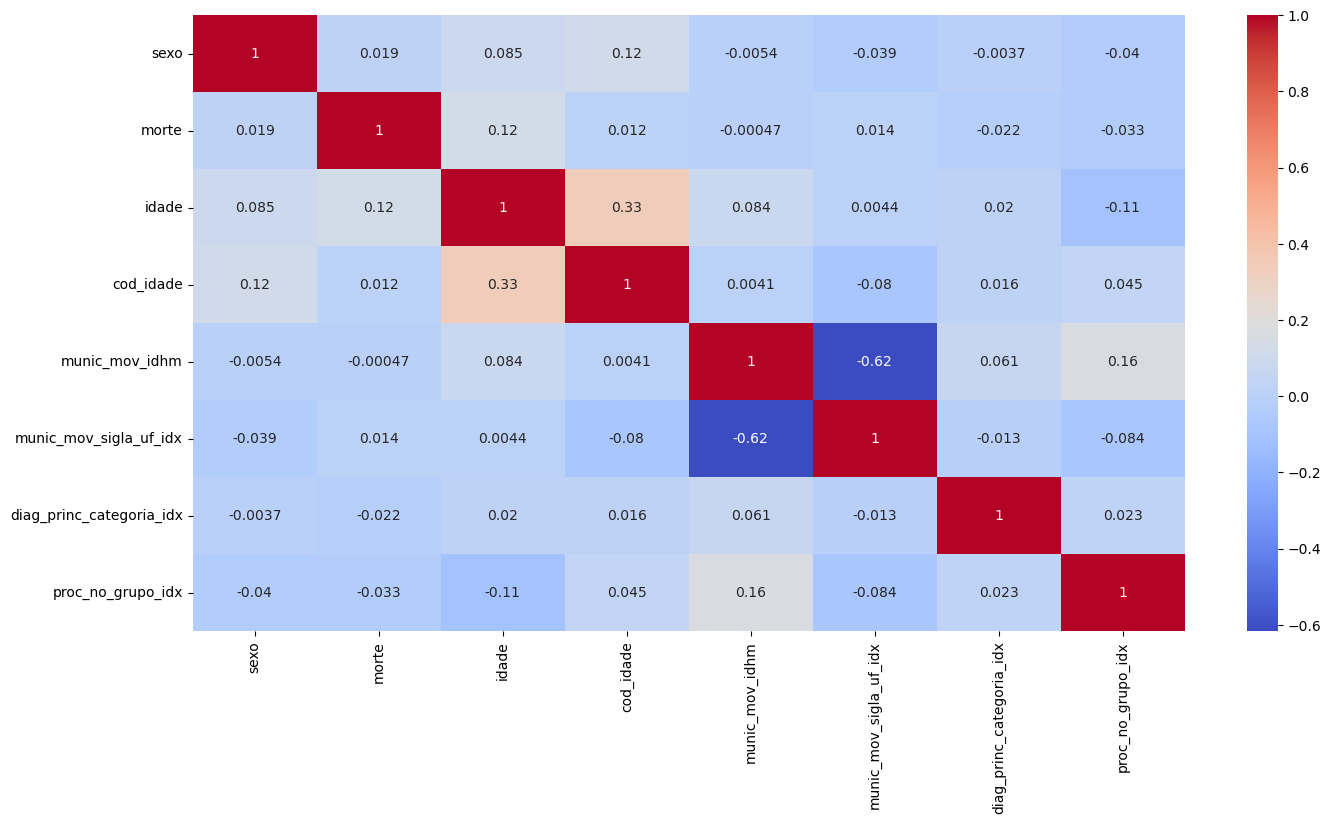

In [32]:
df_t_p = df_transformed.toPandas().set_index("diag_princ_categoria")

fig, ax = plt.subplots(figsize = (16,8))
ax = sns.heatmap(df_t_p.corr(),annot = True, cmap = 'coolwarm')
plt.show()

In [19]:
kmeans = KMeans(featuresCol='features', k=4)
model = kmeans.fit(df_transformed)
resultado = model.transform(df_transformed)

In [42]:
pandas_df = df_transformed.limit(10).select("diag_princ_categoria", "features").toPandas().set_index("diag_princ_categoria")

X = np.array(pandas_df['features'].tolist())

In [43]:
labels_list = pandas_df.index

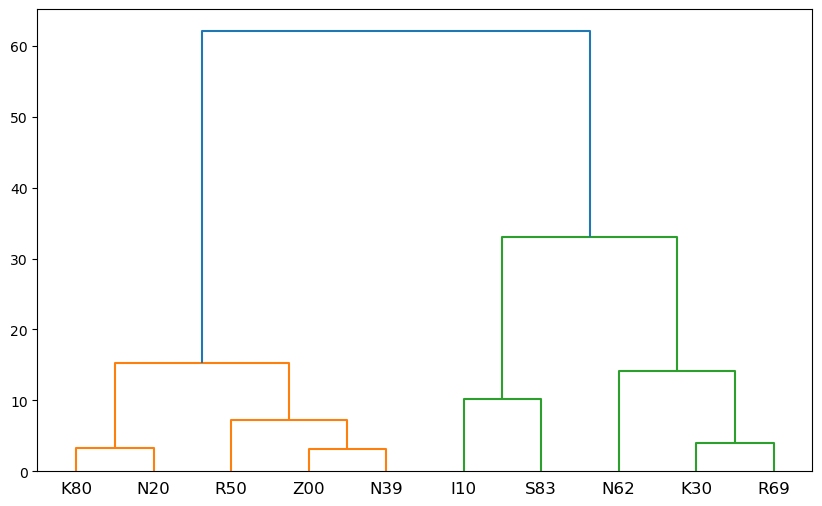

In [44]:
linked = linkage(X,'complete')

plt.figure(figsize=(10, 6))
dendrogram(linked, labels=labels_list)
# plt.title("Dendrograma - Clusterização Hierárquica")
# plt.xlabel("Amostras")
# plt.ylabel("Distância")
plt.show()

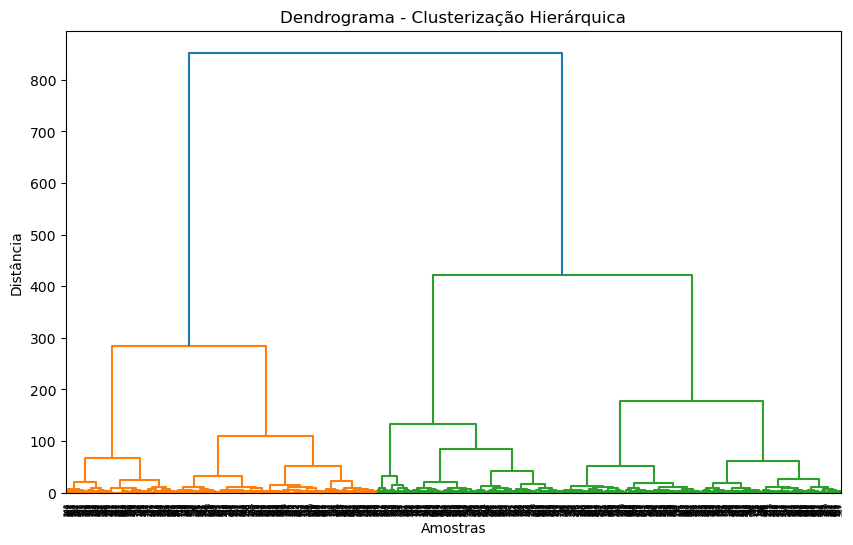

In [25]:
linked = linkage(X, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(linked)
plt.title("Dendrograma - Clusterização Hierárquica")
plt.xlabel("Amostras")
plt.ylabel("Distância")
plt.show()

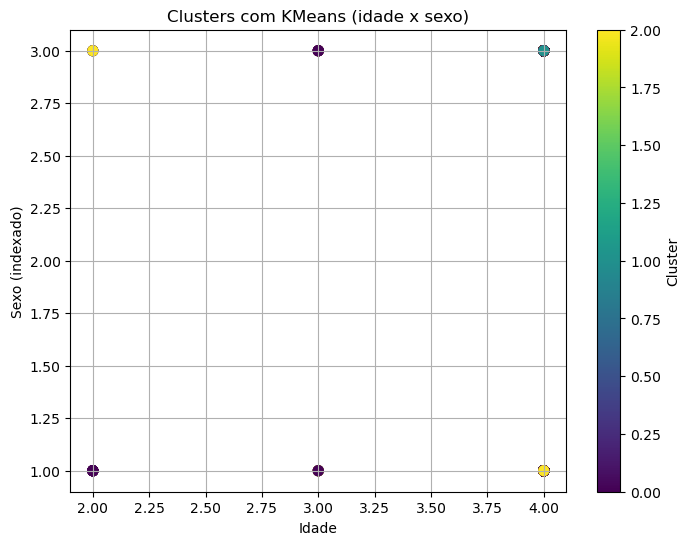

In [28]:
cols_para_plot = colunas_features + ["prediction"]

resultado_pd = resultado.select(*cols_para_plot).toPandas()

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    resultado_pd["cod_idade"],
    resultado_pd["sexo"],
    c=resultado_pd["prediction"],
    cmap="viridis",
    s=50
)

plt.xlabel("Idade")
plt.ylabel("Sexo (indexado)")
plt.title("Clusters com KMeans (idade x sexo)")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.show()